First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

There are 3 datasets, the orginal paper combined the 3 datasets together, but not sure how they are combined since they have different columns. The imbalance is an issue if analyzing each dataset independently.

In [1]:
import sys
sys.path.append('../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
qitta_combine = pd.read_csv('../Data/Qitta_3datasetscombined.csv',index_col=0)

In [3]:
print(qitta_combine.shape)

(1569, 3836)


,Diagnosis,X4454356,X261920,X4474844,X301062,X4455330,X3957916,X2506486,X300250,X4343580,...,X310490,X310492,X4475642,X4428313,X300646,X540982,X288224,X4449633,X225846,X38344
11484.CSM5FZ3X,CD,0,0,0,0,0,0,3,0,34,...,0,0,46,29,0,0,0,0,0,0
11484.CSM5FZ3Z,CD,0,0,0,1,0,0,0,0,9,...,0,0,92,0,0,0,0,0,0,0
11484.MSM5LLIQ,UC,0,0,1,0,0,0,0,0,27,...,1,0,21,5,0,0,0,0,0,0
11484.CSM5FZ3N,CD,0,0,1,0,0,0,2,0,36,...,0,0,15,1,0,0,0,1,0,0
11484.CSM5MCV5,CD,1,0,0,0,0,0,0,0,13,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151.G10483,nonIBD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2151.G11579,nonIBD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2151.G11295,nonIBD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2151.G11157,nonIBD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Extract OTU table and response variable

In [4]:
data = qitta_combine.drop(qitta_combine.columns[0], axis=1)
cols_name = data.columns.tolist()
data = data.values

In [6]:
print(data[:15,:10])
print(np.shape(data))

[[  0   0   0   0   0   0   3   0  34   0]
 [  0   0   0   1   0   0   0   0   9   0]
 [  0   0   1   0   0   0   0   0  27   1]
 [  0   0   1   0   0   0   2   0  36   0]
 [  1   0   0   0   0   0   0   0  13   0]
 [  0   0   0   3   0   0  59   0   1   0]
 [  0   0   0   0   0   0 113   0   0   0]
 [  0   0   0   4   0   0  80   0   0   0]
 [  0   0   0   0   0   0  95   0   2   0]
 [  0   0   0   0   0   0  16   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0  17   0]
 [  0   0   0   0   0   0  20   0   8   0]
 [ 12   0   0   0   0  18   0   0   0   0]
 [  0   0   0   0   0   1  12   0   0   0]]
(1569, 3835)


In [7]:
y = qitta_combine.iloc[:, 0].values 

In [8]:
set(y)

{'CD', 'UC', 'nonIBD'}

In [9]:
#change y into 2 levels
y = np.where(np.isin(y, ['CD', 'UC']), 'IBD', y)

In [10]:
y

array(['IBD', 'IBD', 'IBD', ..., 'nonIBD', 'nonIBD', 'nonIBD'],
      dtype=object)

preprocess the OTU table

In [12]:
# 1. abundance matrix--> relative abundance matrix
data=FS.relative_abundance(data)
print(np.shape(data))

(1569, 3835)


In [13]:
print(data[:10,:10])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.46943574e-05 0.00000000e+00
  1.66536050e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30512422e-06
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.77461180e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.84791501e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.03893705e-04 3.84791501e-06]
 [0.00000000e+00 0.00000000e+00 3.64794420e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.29588840e-06 0.00000000e+00
  1.31325991e-04 0.00000000e+00]
 [4.92994547e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.40892912e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.03908500e-06
  0.00000000e+00 0.00000000e+00 1.77768672e-04 0.00000000e+00
  3.01302833e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [14]:
# 2. calculating H score for each OTU
weights=FS.OTU_H_Score_fun(data,y)

In [18]:
print(min(weights));print(max(weights));print(len(weights))

0.0
203.57286831967502
3835


In [16]:
weights

array([0.80968858, 0.        , 0.        , ..., 0.        , 2.43216536,
       0.        ])

In [44]:
# check the function
data_test = data.copy()
data_test[data_test<0.01] =0

In [28]:
# Group the data by the unique values in the response variable
groups1 = [data_test[y == group, 0] for group in np.unique(y)]
# Perform the Kruskal-Wallis test
stat, p_value = kruskal(*groups1)
# Store the results in a dictionary
print(stat, p_value)

0.8096885814150787 0.3682123377053419


In [41]:
selectedOTU_index[295:305]

[2667, 292, 1893, 3007, 1918]

In [42]:
weights[selectedOTU_index[295:305]]

array([2.91966544, 2.88464932, 2.7778359 , 2.75111728, 2.73227216])

In [43]:
# Group the data by the unique values in the response variable
groups1 = [data_test[y == group, 2667] for group in np.unique(y)]
# Perform the Kruskal-Wallis test
stat, p_value = kruskal(*groups1)
# Store the results in a dictionary
print(stat, p_value)

2.919665444368609 0.08750600513361877


In [29]:
# 3. determine the elbowpoint and the select indices of the features
selectedOTU_index, eps=FS.indice_H_unisig(weights,y)

In [21]:
print(eps)

300


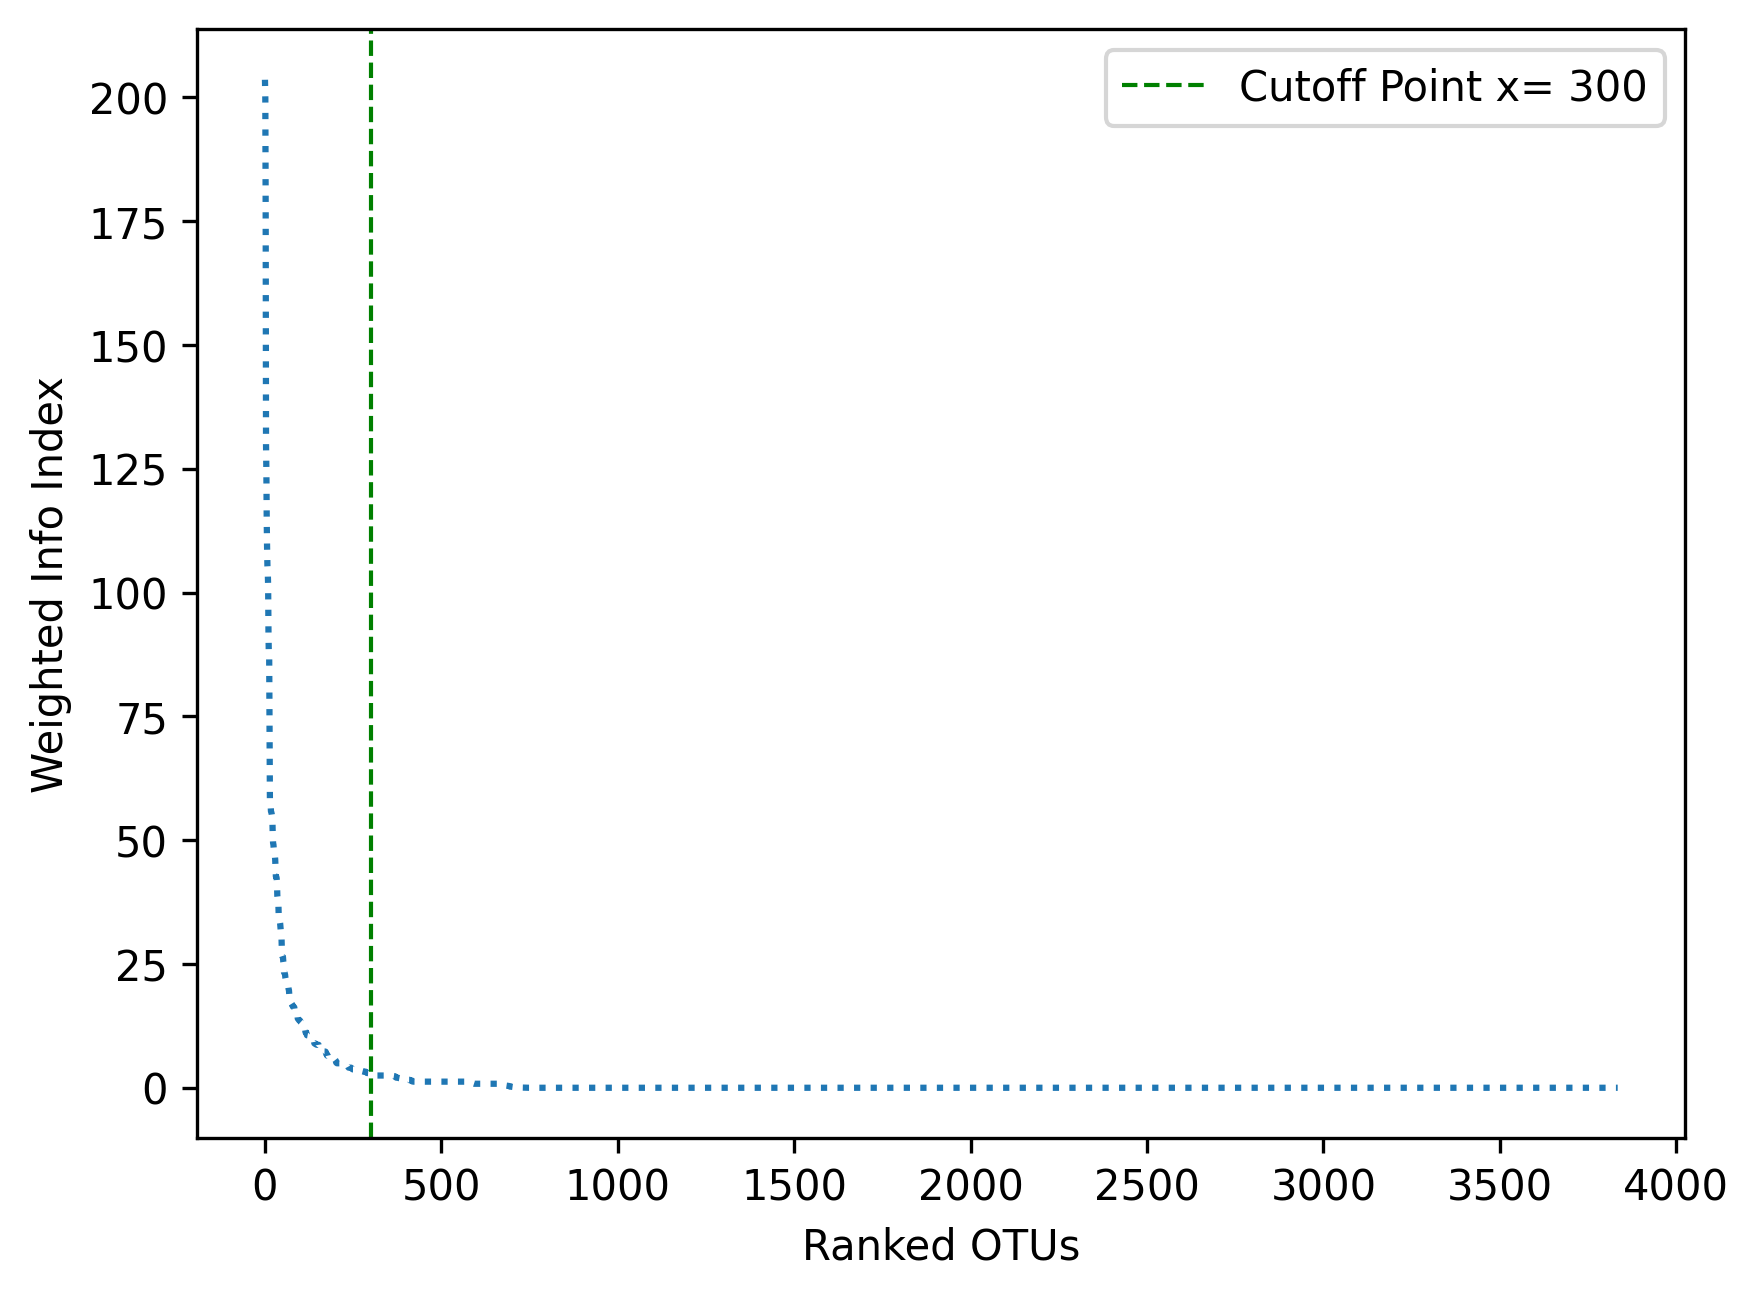

In [31]:
#plot the h statistics and cutoff descendingly
FS.plotWeightedIndex(weights,threshold=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [24]:
# 4. subset the relative matrix by the select indices

In [32]:
X_FS = data[:,selectedOTU_index]

In [26]:
np.shape(X_FS)

(1569, 300)

Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method, repeat the  process iter=20 times to  find the mean accuracy and AUC)---> use random forest and SVM as classifier

In [27]:
iter =30
cls = ["RF","SVM"]

In [28]:
targetLabel=y
X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
print(np.shape(X_lasso))

(1569, 45)


In [29]:
print(xlabel_lasso)

[  25  139  276  409  491  533  825  874  956 1141 1192 1251 1357 1502
 1675 1717 1781 1784 1836 1917 1997 2002 2098 2227 2301 2309 2339 2341
 2402 2424 2793 2852 2858 2920 2922 2937 2983 3187 3212 3256 3262 3279
 3296 3576 3810]


In [30]:
print(np.shape(data))
print(len(xlabel_lasso))

(1569, 3835)
45


In [31]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso))

(1569, 3835)
(1569, 300)
(1569, 45)


started modeling, the  function will print out the accuracy and AUC for each dataset using each classifier. and also will return the y_actual, y_predict, y_predprob

In [32]:
# the result of 5-fold cross validation
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.954095  0.990397      0.755892  0.850046
SelectMicro     0.954732  0.990245      0.761627  0.850261
Lasso           0.941993  0.981204      0.558312  0.893950
Random          0.938845  0.982972      0.548868  0.503888


In [33]:
# Save dictionary to a pickle file
with open('../results/dict_cm_qitta_update.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [34]:
# Load dictionary from the pickle file
with open('../results/dict_cm_qitta_update.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

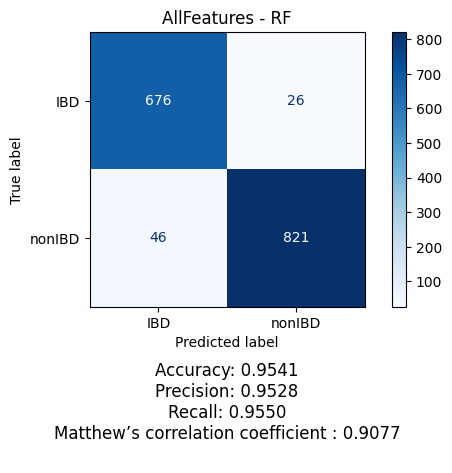

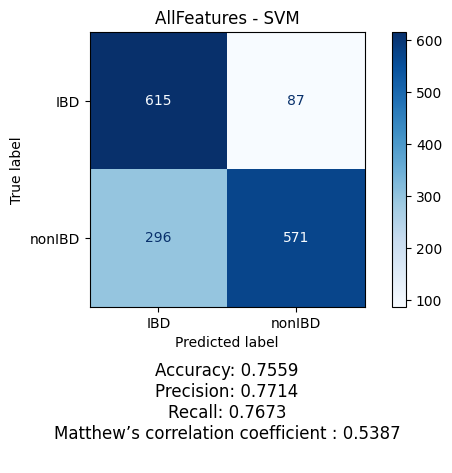

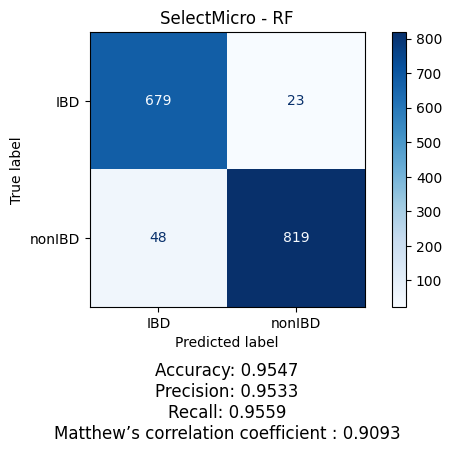

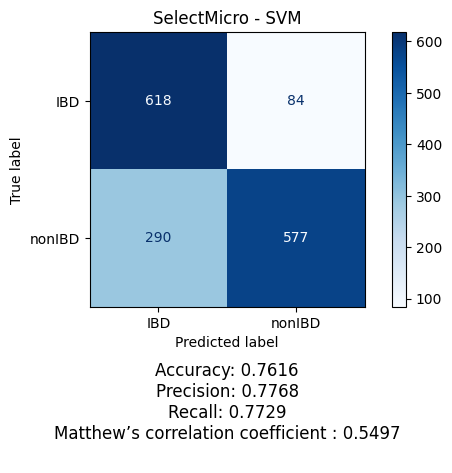

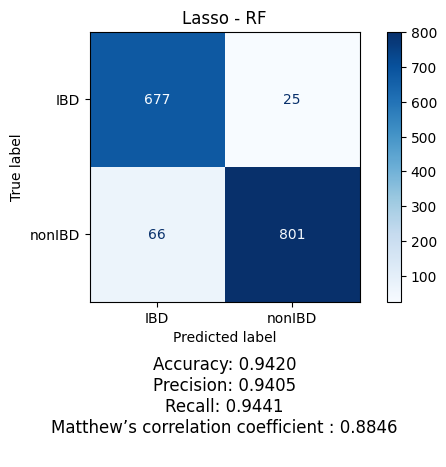

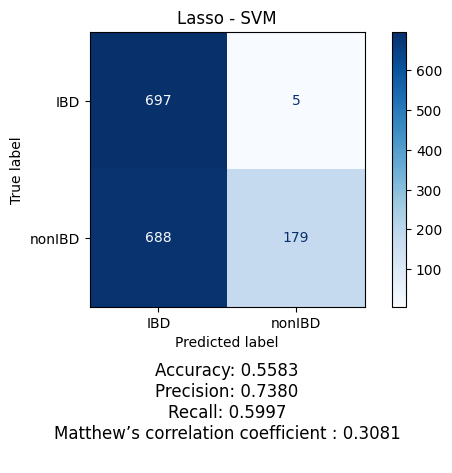

In [35]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [48]:
selectedASVs0=[cols_name[i] for i in selectedOTU_index]

In [49]:
selectedASVs0

['X1096610',
 'X4347159',
 'X505670',
 'X4371061',
 'X4397098',
 'X4429335',
 'X4483570',
 'X4476950',
 'X4481613',
 'X4430843',
 'X753638',
 'X138179',
 'X755148',
 'X246717',
 'X495451',
 'X328472',
 'X1000986',
 'X3090117',
 'X4462432',
 'X3805726',
 'X190233',
 'X4352657',
 'X760967',
 'X1100471',
 'X4449236',
 'X4468891',
 'X4423553',
 'X134786',
 'X4475758',
 'X4483963',
 'X4469576',
 'X874462',
 'X134265',
 'X503372',
 'X3138798',
 'X4356080',
 'X191718',
 'X30062',
 'X4484034',
 'X14280',
 'X4102199',
 'X4464173',
 'X847228',
 'X129798',
 'X964363',
 'X851668',
 'X495017',
 'X4471245',
 'X455407',
 'X4410166',
 'X253584',
 'X851821',
 'X495007',
 'X181422',
 'X4468506',
 'X4349519',
 'X4453609',
 'X4446058',
 'X4425214',
 'X4449244',
 'X4474951',
 'X4434334',
 'X801210',
 'X4419276',
 'X4483045',
 'X4447072',
 'X4424063',
 'X4426298',
 'X4468391',
 'X198185',
 'X4479405',
 'X2582660',
 'X4447950',
 'X165118',
 'X548475',
 'X4477861',
 'X2617854',
 'X4372973',
 'X4439606',
 'X44

## compare the first 45 index

In [61]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=60
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)

In [62]:
# the column names of the featues
ASVs = cols_name
selectedASVs15=[ASVs[i] for i in selectedOTU_index_15]

{'nonIBD', 'IBD'}
702 867


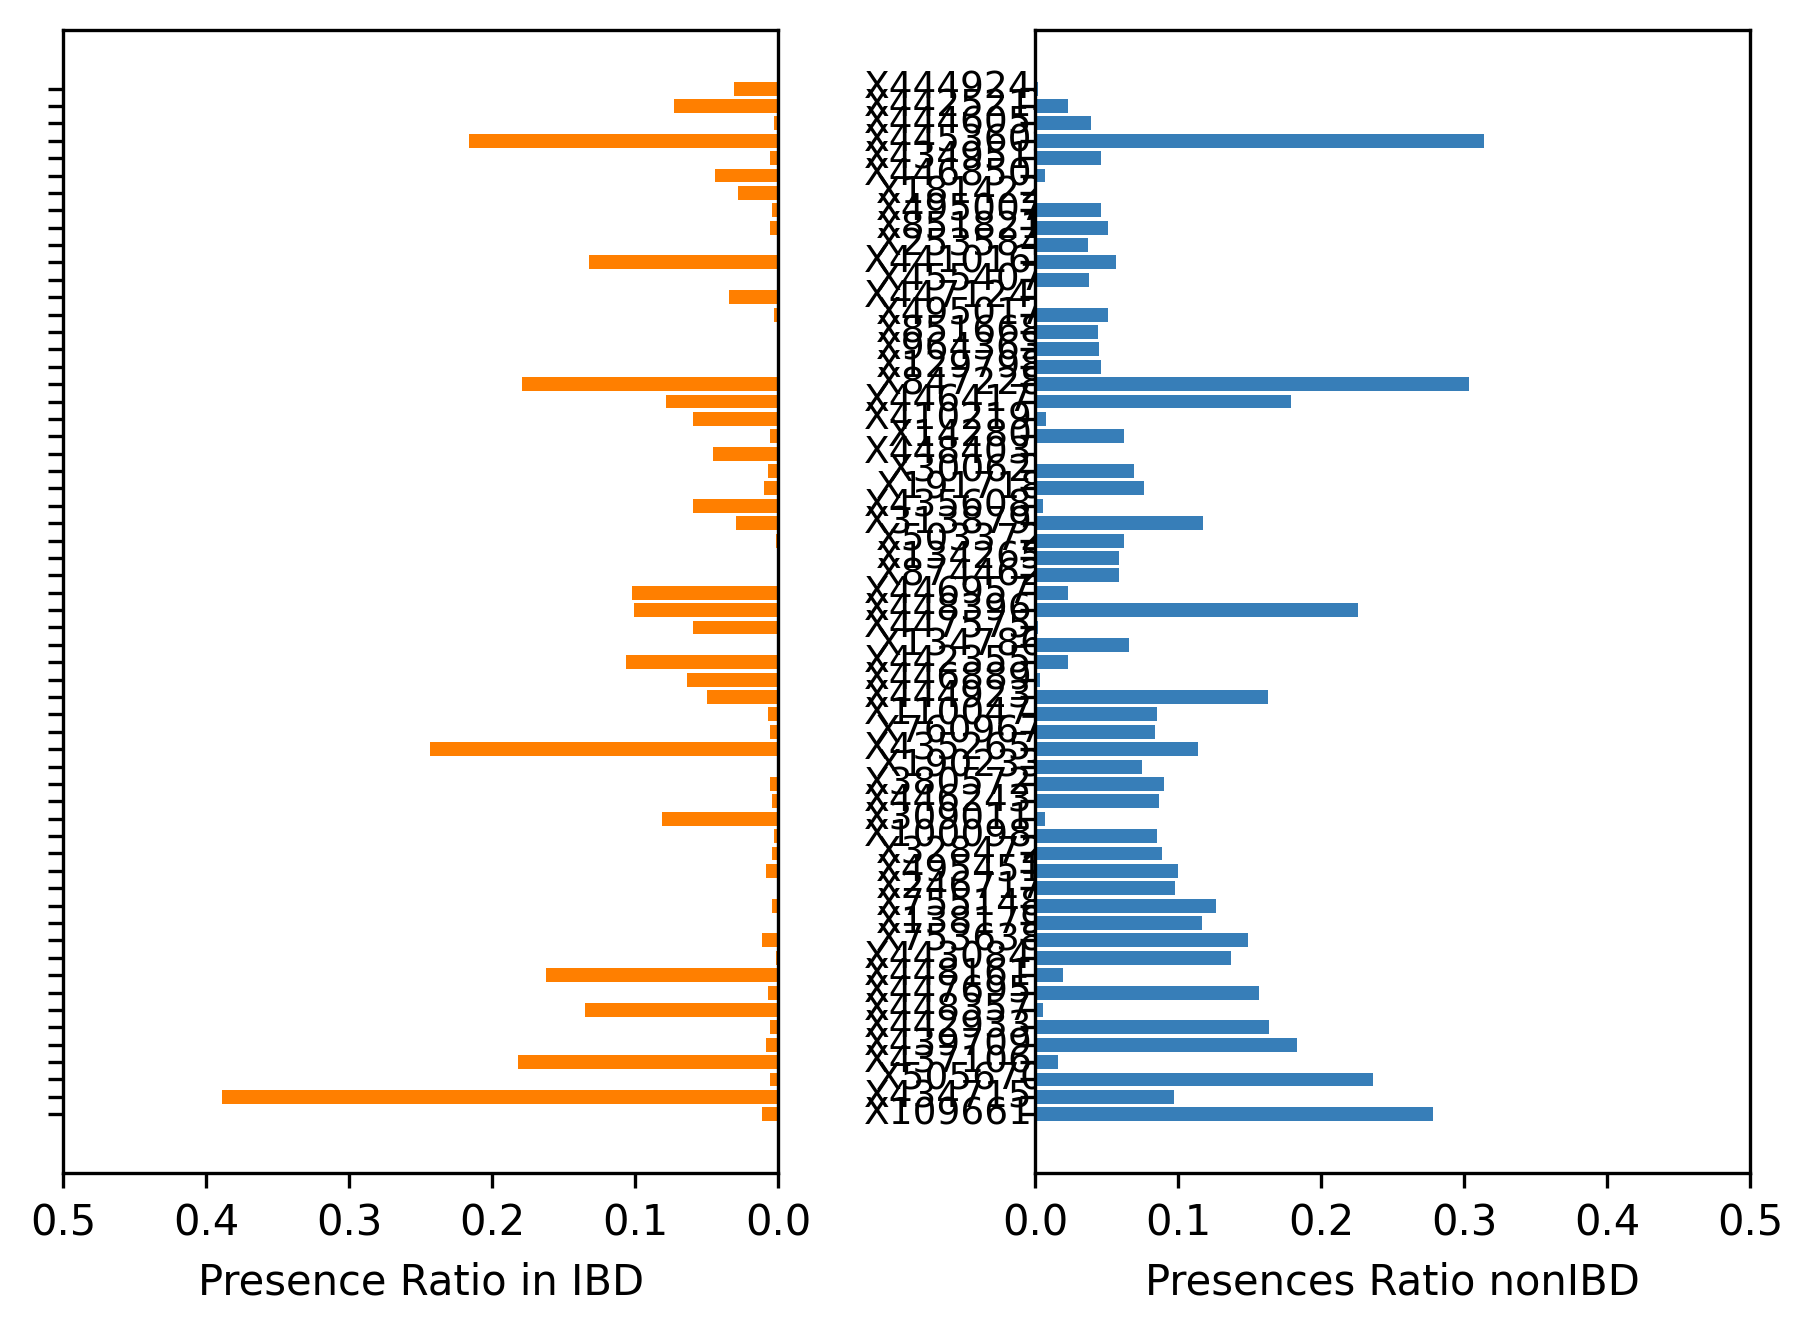

In [39]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs15,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)

702 867


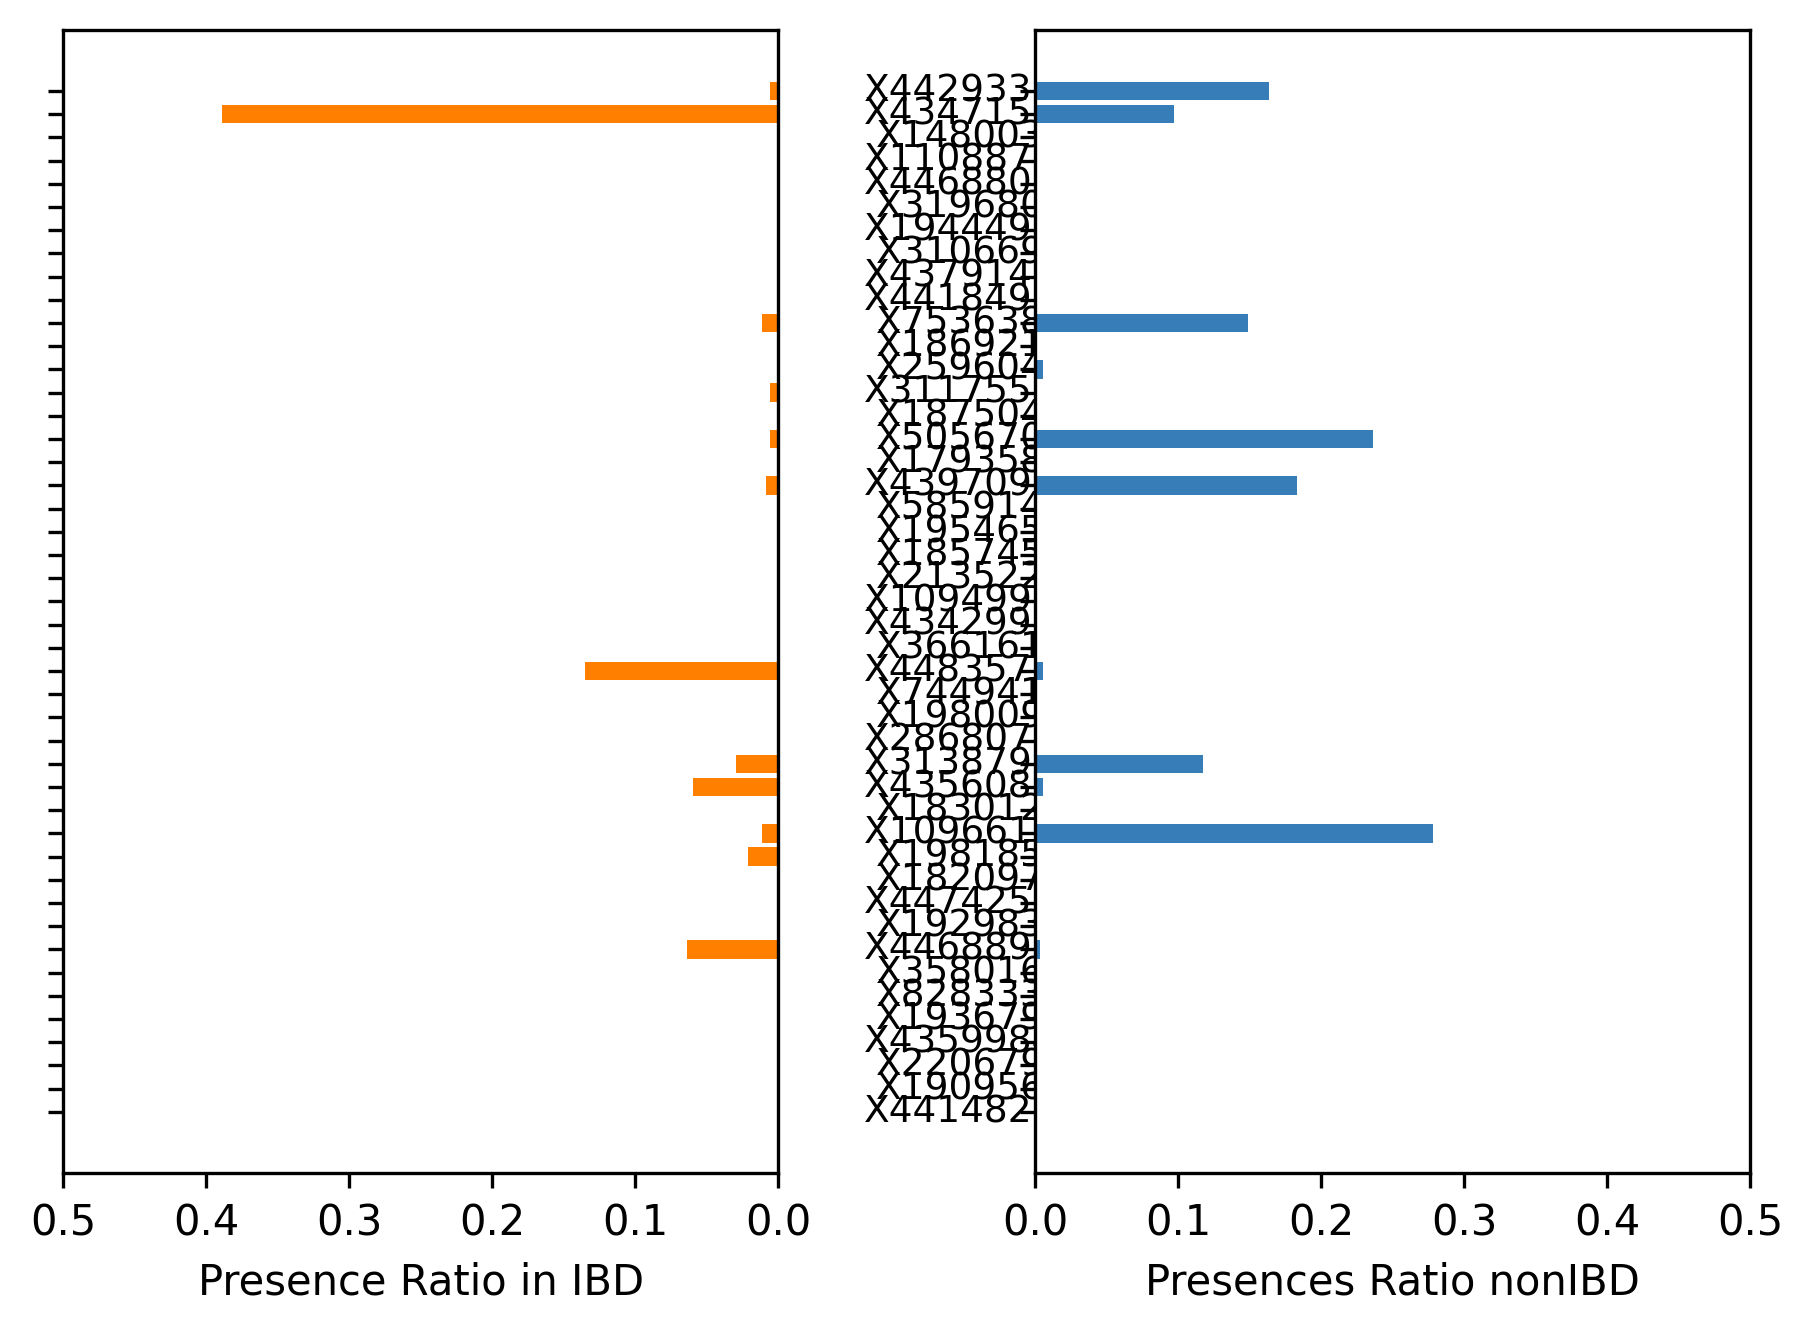

In [40]:
selectedASV_lasso = [cols_name[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=45)

In [41]:
selectedASV_lasso

['X4414821',
 'X190956',
 'X220679',
 'X4359984',
 'X193679',
 'X828333',
 'X358016',
 'X4468891',
 'X192983',
 'X4474255',
 'X182097',
 'X198185',
 'X1096610',
 'X183012',
 'X4356080',
 'X3138798',
 'X2868079',
 'X198009',
 'X744941',
 'X4483570',
 'X366161',
 'X4342992',
 'X1094991',
 'X213522',
 'X185745',
 'X195465',
 'X585914',
 'X4397098',
 'X179358',
 'X505670',
 'X187504',
 'X3117556',
 'X259604',
 'X186921',
 'X753638',
 'X4418496',
 'X4379143',
 'X310669',
 'X1944498',
 'X319680',
 'X4468809',
 'X1108877',
 'X148003',
 'X4347159',
 'X4429335']

In [42]:
qitta_combine[['Diagnosis','X4414821']].value_counts()

Diagnosis  X4414821
nonIBD     0           857
CD         0           301
UC         0           281
           1            34
CD         1            21
UC         2            18
           3            10
CD         2             6
nonIBD     1             6
UC         4             5
           5             4
           11            4
nonIBD     2             3
UC         6             2
           10            2
           14            2
           7             2
CD         4             2
           5             1
           19            1
           15            1
           9             1
           6             1
           3             1
UC         8             1
           21            1
nonIBD     3             1
Name: count, dtype: int64

,Kingdom,Phylum,Class,Order,Family,Genus,Species
X4479946,Bacteria,Proteobacteria,Betaproteobacteria,MND1,NaN,NaN,NaN
X4307314,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,NaN,NaN
X4376890,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Methyloversatilis,NaN
X337735,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Dorea,NaN
X347991,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Oscillospira,NaN
...,...,...,...,...,...,...,...
X885628,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Alloiococcus,otitis
X4374322,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,venetianus
X219094,Bacteria,Verrucomicrobia,[Pedosphaerae],[Pedosphaerales],NaN,NaN,NaN
X66199,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Azomonas,NaN


### Analyze the significant OTU

In [67]:
selectedASVs5=[cols_name[i] for i in selectedOTU_index[:5]]

In [51]:
qitta_TAX = pd.read_csv('../Data/Qitta_tax.csv',index_col=0)

In [68]:
selectedASVs5

['X1096610', 'X4347159', 'X505670', 'X4371061', 'X4397098']